# Investing problems in Neural Network Training: BatchNormalization

### Importing necessary libraries

In [1]:
import random
import torch
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Reading the data

In [2]:
words = open("./data/names.txt", "r").read().splitlines()
len(words)

32033

### Building the Vocabulory

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Build the dataset

In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP Training

#### Defining the parameters

In [5]:
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

11897


### Training MLP: Gradient Descent

In [6]:
g = torch.Generator().manual_seed(2147483647)

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 27.1911
  10000/ 200000: 2.2922
  20000/ 200000: 2.5713
  30000/ 200000: 2.4401
  40000/ 200000: 2.1547
  50000/ 200000: 2.5038
  60000/ 200000: 2.0935
  70000/ 200000: 2.3803
  80000/ 200000: 2.4640
  90000/ 200000: 1.9567
 100000/ 200000: 2.2668
 110000/ 200000: 2.1418
 120000/ 200000: 2.1423
 130000/ 200000: 1.7248
 140000/ 200000: 2.0902
 150000/ 200000: 2.3198
 160000/ 200000: 1.9968
 170000/ 200000: 1.6930
 180000/ 200000: 2.5656
 190000/ 200000: 2.2532


#### Plotting Loss

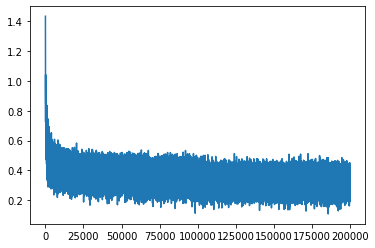

In [7]:
plt.plot(lossi)

#### Train loss vs Dev loss

In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    
    # Forward pass to get the loss
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation Layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    return (split, loss.item())


In [9]:
print(split_loss('train'))
print(split_loss('val'))

('train', 2.1256396770477295)
('val', 2.1730308532714844)


### Problems in Neural Network Training

#### Initial Loss: Softmax Confidently wrong

In [10]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 27.8817


- In a Neural Network we almost always can predict the loss at initialization
- Here at initialization we want the probability to be uniform for all the characters :  1/27 over here
- Hence logprobs should be -log(1/27) in our case
- Example to show this : 

#### Ideal loss for us

In [11]:
-torch.tensor(1/27).log()

tensor(3.2958)

#### Loss and probs for uniform distribution

In [12]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim = 0)
probs # Equal probability distribution - We expect this over here as well

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [13]:
loss = -torch.log(probs)
loss

tensor([1.3863, 1.3863, 1.3863, 1.3863])

#### Loss for gaussian distribution

In [14]:
logits = torch.rand(4)*20
probs = F.softmax(logits, dim = 0)
probs # Equal probability distribution - We expect this over here as well

tensor([1.9777e-02, 9.3926e-04, 9.7928e-01, 5.6471e-06])

In [15]:
loss = -torch.log(probs)
loss

tensor([ 3.9233,  6.9704,  0.0209, 12.0844])

#### Why our initial loss is bad 

- For the initial case we wan't our logits to be close to zero, as loss = F.cross_entropy(logits)
- But logits = h @ w2 + b2: so for logits to be close to zero, we need to scale the W2 and b2 accordingly
- Basically squash the W2 and b2 close to 0

In [16]:
logits

tensor([15.9056, 12.8584, 19.8079,  7.7445])

#### Fixing initial loss

In [17]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)*0.01
b2 = torch.randn(vocab_size, generator = g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3221


#### Full Training After Fixing Initial Loss

In [18]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)*0.01
b2 = torch.randn(vocab_size, generator = g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


11897
      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


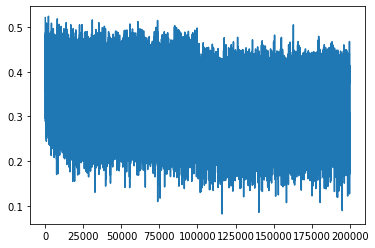

In [19]:
## We find that the hockey shape of the loss has now normalized

plt.plot(lossi)

In [20]:
print(split_loss('train'))
print(split_loss('val'))

('train', 2.069589138031006)
('val', 2.1310744285583496)


### Problem with tanh layer being too saturated at init
<br></br>
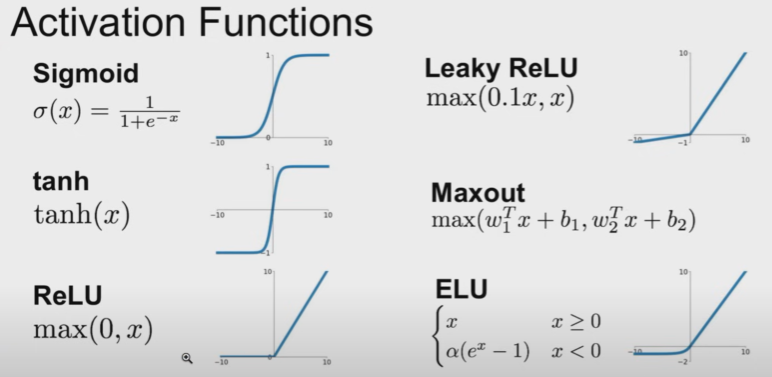

In [21]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)*0.01
b2 = torch.randn(vocab_size, generator = g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3221


In [22]:
## We see a lot of the values of the activation end up near 1 or -1
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

(array([2069.,  144.,  106.,   82.,   59.,   56.,   44.,   30.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

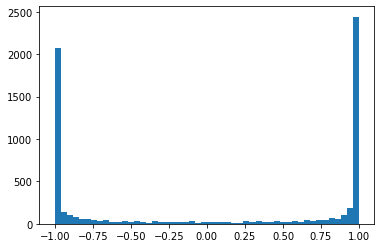

In [23]:
plt.hist(h.view(-1).tolist(), 50)

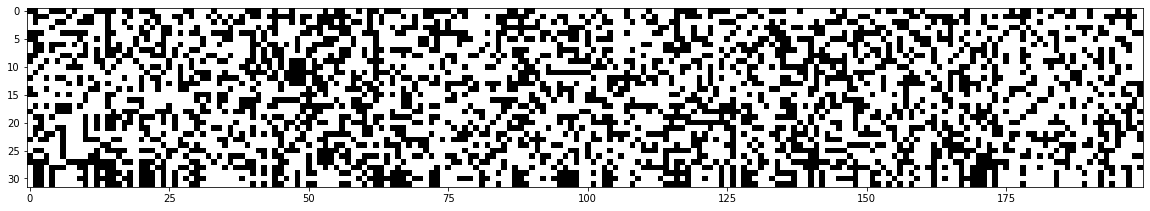

In [24]:
## The graph is bad, because if there is any column which is totally white that means that neuron is dead

plt.figure(figsize = (20,18))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation = 'nearest')

(array([  2.,   2.,   1.,   4.,   2.,   4.,   6.,  15.,   5.,  25.,  32.,
         49.,  56.,  59.,  92., 119., 134., 197., 195., 221., 257., 275.,
        297., 341., 353., 375., 369., 349., 358., 362., 271., 312., 229.,
        206., 190., 167.,  87., 111.,  72.,  55.,  41.,  22.,  23.,  18.,
         17.,   8.,   5.,   7.,   2.,   1.]),
 array([-19.05793571, -18.31571732, -17.57349892, -16.83128052,
        -16.08906212, -15.34684372, -14.60462532, -13.86240692,
        -13.12018852, -12.37797012, -11.63575172, -10.89353333,
        -10.15131493,  -9.40909653,  -8.66687813,  -7.92465973,
         -7.18244133,  -6.44022293,  -5.69800453,  -4.95578613,
         -4.21356773,  -3.47134933,  -2.72913094,  -1.98691254,
         -1.24469414,  -0.50247574,   0.23974266,   0.98196106,
          1.72417946,   2.46639786,   3.20861626,   3.95083466,
          4.69305305,   5.43527145,   6.17748985,   6.91970825,
          7.66192665,   8.40414505,   9.14636345,   9.88858185,
         10.630800

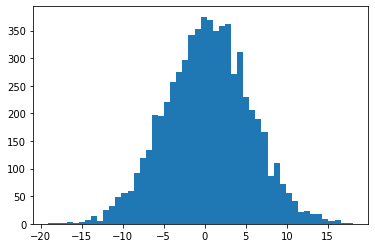

In [25]:
plt.hist(hpreact.view(-1).tolist(), 50)

#### Why is this a problem for us ? 
- If the h values are very close to -1 or 1 then it lies near the tail of tanh.
- In this case durinmg backpropagation, the grad becomes zero as the local grad value is (1-t^2), or the grads.
- So we end up in a lot of dead neurons in case the tanh value saturates.
- The same problem occurs with any activation functions that have flat tails, beacuse incase the vale of any neuron with that non-linearity ends up in that flat region, then they will never get updated as they won't allow any gradient to flow through them.
- So its kinda a permanent brain damage, as that neuron never learns/activates.

#### Fixing the issue: Scaling the hpreact via W1 and b1

In [26]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)*0.15
b1 = torch.randn(n_hidden, generator = g)*0
W2 = torch.randn((n_hidden, vocab_size), generator = g)*0.01
b2 = torch.randn(vocab_size, generator = g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3105


In [27]:
h

tensor([[ 0.4460, -0.0726, -0.5389,  ..., -0.2678, -0.9273,  0.7838],
        [-0.8082, -0.1378, -0.1384,  ...,  0.0348,  0.3932,  0.3362],
        [ 0.6873,  0.0955,  0.7044,  ...,  0.2173,  0.5283,  0.7766],
        ...,
        [-0.8248,  0.4140, -0.0262,  ..., -0.0646,  0.7603,  0.7795],
        [-0.8522,  0.0772, -0.2135,  ..., -0.0970,  0.6684,  0.8153],
        [-0.8248,  0.4140, -0.0262,  ..., -0.0646,  0.7603,  0.7795]],
       grad_fn=<TanhBackward0>)

(array([ 37.,  69.,  97.,  97., 114., 120., 138., 118., 134., 133., 124.,
        115., 153., 105., 124., 144., 132., 132., 110., 128., 135., 140.,
        153., 127., 127., 149., 128., 142., 121., 145., 159., 144., 126.,
        151., 120., 141., 131., 152., 130., 165., 157., 147., 161., 133.,
        161., 133., 128., 125.,  84.,  61.]),
 array([-0.9929316 , -0.95330804, -0.91368448, -0.87406093, -0.83443737,
        -0.79481381, -0.75519025, -0.71556669, -0.67594313, -0.63631957,
        -0.59669601, -0.55707245, -0.51744889, -0.47782533, -0.43820177,
        -0.39857821, -0.35895465, -0.31933109, -0.27970753, -0.24008397,
        -0.20046041, -0.16083685, -0.12121329, -0.08158973, -0.04196617,
        -0.00234261,  0.03728095,  0.07690451,  0.11652807,  0.15615163,
         0.19577519,  0.23539875,  0.27502231,  0.31464587,  0.35426943,
         0.39389299,  0.43351655,  0.47314011,  0.51276366,  0.55238722,
         0.59201078,  0.63163434,  0.6712579 ,  0.71088146,  0.75050502,
 

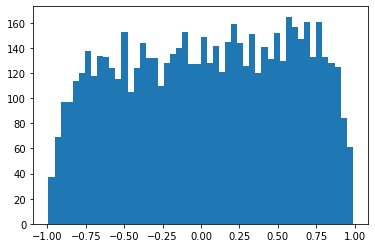

In [28]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  39.,  77.,  64.,  99., 134., 169., 187., 219., 224., 275.,
        308., 311., 355., 369., 379., 357., 366., 333., 292., 284., 287.,
        244., 187., 170., 134., 104.,  82.,  74.,  41.,  30.,  27.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-2.82086229, -2.71313657, -2.60541085, -2.49768513, -2.38995941,
        -2.28223369, -2.17450797, -2.06678225, -1.95905653, -1.85133081,
        -1.74360509, -1.63587937, -1.52815365, -1.42042793, -1.31270221,
        -1.20497649, -1.09725077, -0.98952505, -0.88179933, -0.77407361,
        -0.66634789, -0.55862216, -0.45089644, -0.34317072, -0.235445  ,
        -0.12771928, -0.01999356,  0.08773216,  0.19545788,  0.3031836 ,
         0.41090932,  0.51863504,  0.62636076,  0.73408648,  0.8418122 ,
         0.94953792,  1.05726364,  1.16498936,  1.27271508,  1.3804408 ,
         1.48816652,  1.59589224,  1.70361796,  1.81134368,  1.9190694 ,
 

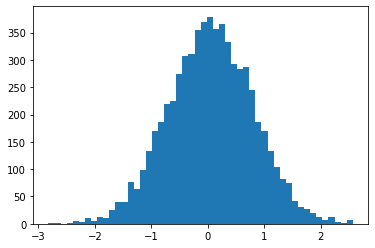

In [29]:
plt.hist(hpreact.view(-1).tolist(), 50)

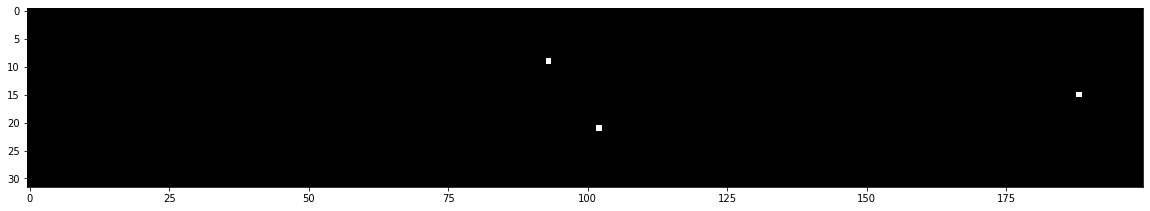

In [30]:
plt.figure(figsize = (20,18))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation = 'nearest')

### Are we going to these optimiztions manually ?

#### Lets see some Gaussian characteristics before answering

tensor(0.0067) tensor(1.0004)
tensor(-0.0210) tensor(3.1734)


(array([1.27618292e-05, 0.00000000e+00, 1.27618292e-05, 2.55236583e-05,
        5.74282313e-05, 2.55236583e-05, 1.02094633e-04, 1.21237377e-04,
        2.80760242e-04, 5.04092252e-04, 7.08281519e-04, 1.25704017e-03,
        2.07379724e-03, 3.31807558e-03, 5.61520483e-03, 9.22680249e-03,
        1.49121974e-02, 2.22821537e-02, 3.44441769e-02, 4.93882789e-02,
        6.79695022e-02, 8.94221370e-02, 1.10466393e-01, 1.28435049e-01,
        1.35990052e-01, 1.32410359e-01, 1.18914724e-01, 1.00059122e-01,
        7.77961106e-02, 5.58074790e-02, 3.99700490e-02, 2.66786039e-02,
        1.81217974e-02, 1.14601226e-02, 7.24871897e-03, 4.65806765e-03,
        2.66722230e-03, 1.48037218e-03, 9.06089871e-04, 5.93425056e-04,
        3.12664815e-04, 2.16951096e-04, 9.57137188e-05, 3.82854875e-05,
        4.46664021e-05, 3.19045729e-05, 6.38091458e-06, 6.38091458e-06,
        0.00000000e+00, 6.38091458e-06]),
 array([-19.39110947, -18.60752274, -17.823936  , -17.04034927,
        -16.25676254, -15.4731

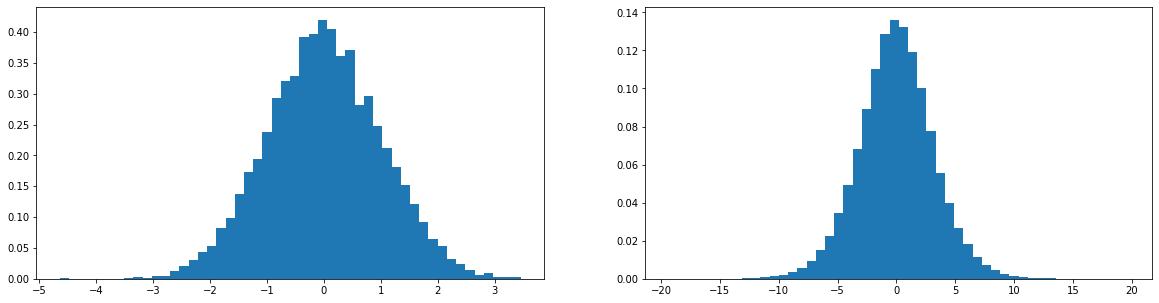

In [31]:
x = torch.randn((1000, 10), generator = g)
w = torch.randn((10, 200), generator = g)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = "True")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = "True")

#### Tips
- We want the activations to be some numbers between -1 and 1 mostly for activations like tanh
- So in essence we want the activations to be similar to zero mean unit gaussians
- We say that as we scale a gaussian, its spread scales
- So question arises that what number do we need to multiply the x or w with so that the resultant y is unit gaussian
- Literature says that we need to multiply with the square root of the fan_in

tensor(0.0071) tensor(1.0037)
tensor(0.0021) tensor(0.6517)


(array([3.20317444e-05, 0.00000000e+00, 3.20317444e-05, 6.40634887e-05,
        1.92190466e-04, 3.20317444e-04, 8.32825353e-04, 8.96888842e-04,
        1.85784117e-03, 3.10707920e-03, 4.99695212e-03, 7.43136469e-03,
        1.30369200e-02, 2.14612687e-02, 3.42099030e-02, 5.48063146e-02,
        8.28020591e-02, 1.26237104e-01, 1.82324689e-01, 2.61154812e-01,
        3.46967855e-01, 4.50782738e-01, 5.63982923e-01, 6.38424697e-01,
        6.66644663e-01, 6.41339585e-01, 5.77916732e-01, 4.76504229e-01,
        3.73586234e-01, 2.80790271e-01, 2.03369545e-01, 1.37992755e-01,
        9.21553285e-02, 5.98673302e-02, 3.80537123e-02, 2.48566336e-02,
        1.54072690e-02, 9.35326935e-03, 4.90085689e-03, 3.04301571e-03,
        1.79377768e-03, 1.18517454e-03, 7.04698376e-04, 4.80476165e-04,
        2.56253955e-04, 6.40634887e-05, 3.20317444e-05, 3.20317444e-05,
        3.20317444e-05, 3.20317444e-05]),
 array([-3.84105968, -3.68496453, -3.52886938, -3.37277423, -3.21667908,
        -3.06058393, 

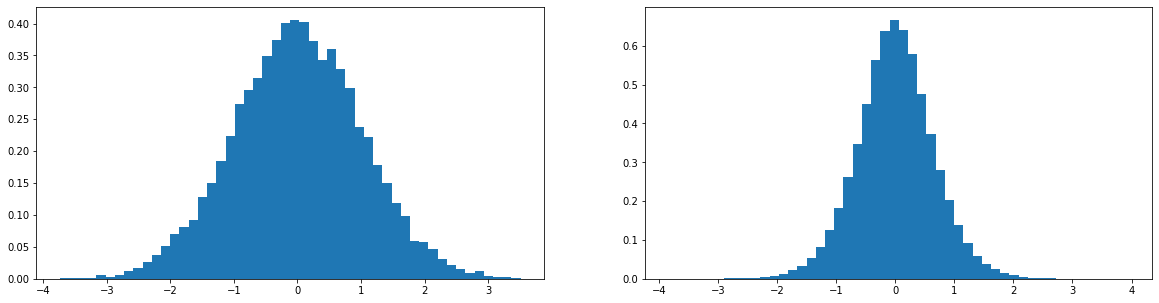

In [32]:
## Spread of y decreased

x = torch.randn((1000, 10), generator = g)
w = torch.randn((10, 200), generator = g)*0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = "True")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = "True")

tensor(-0.0099) tensor(0.9982)
tensor(-0.0238) tensor(6.2461)


(array([3.30599741e-06, 0.00000000e+00, 3.30599741e-06, 9.91799224e-06,
        1.65299871e-05, 2.64479793e-05, 5.28959586e-05, 5.62019560e-05,
        1.61993873e-04, 1.95053847e-04, 4.79369625e-04, 7.63685402e-04,
        1.36207093e-03, 2.19518228e-03, 3.44484930e-03, 5.73921151e-03,
        8.78403512e-03, 1.31082797e-02, 1.90359331e-02, 2.68975949e-02,
        3.61742237e-02, 4.75435488e-02, 5.73689731e-02, 6.66389898e-02,
        6.99449872e-02, 6.65100559e-02, 5.94186915e-02, 4.96461631e-02,
        3.86140498e-02, 2.82960318e-02, 2.00707103e-02, 1.38719651e-02,
        9.37911466e-03, 6.00369130e-03, 3.59692518e-03, 2.30758619e-03,
        1.49431083e-03, 8.52947332e-04, 4.79369625e-04, 2.64479793e-04,
        1.91747850e-04, 9.91799224e-05, 3.63659715e-05, 2.31419819e-05,
        1.32239896e-05, 6.61199482e-06, 6.61199482e-06, 3.30599741e-06,
        3.30599741e-06, 3.30599741e-06]),
 array([-37.19866562, -35.68626274, -34.17385986, -32.66145699,
        -31.14905411, -29.6366

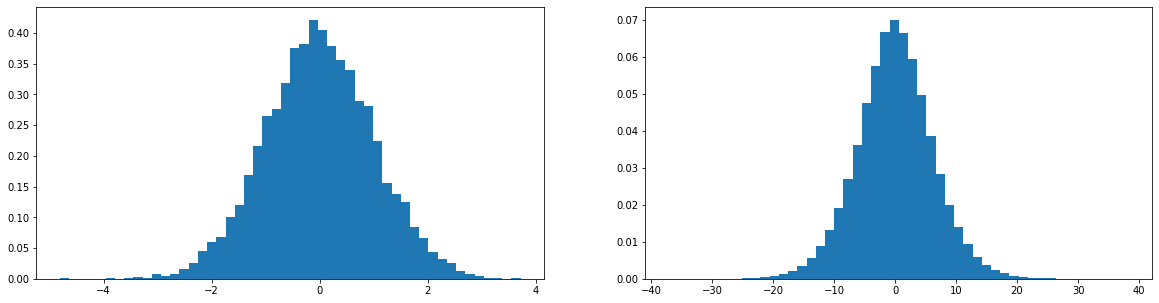

In [33]:
## Spread of y increased

x = torch.randn((1000, 10), generator = g)
w = torch.randn((10, 200), generator = g)*2.0
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = "True")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = "True")

tensor(-0.0094) tensor(0.9948)
tensor(-0.0151) tensor(9.9572)


(array([1.99245466e-06, 0.00000000e+00, 1.99245466e-06, 1.99245466e-06,
        7.96981864e-06, 7.96981864e-06, 5.97736398e-06, 1.39471826e-05,
        3.18792746e-05, 9.16529144e-05, 9.96227330e-05, 1.55411464e-04,
        2.37102105e-04, 4.70219300e-04, 7.03336495e-04, 1.30904271e-03,
        2.13391894e-03, 3.45491638e-03, 5.36966531e-03, 7.94989409e-03,
        1.22336716e-02, 1.72805593e-02, 2.39014861e-02, 3.16979612e-02,
        3.79403216e-02, 4.28357827e-02, 4.37543043e-02, 4.13653512e-02,
        3.46906281e-02, 2.76393310e-02, 2.03190526e-02, 1.47581117e-02,
        1.00579111e-02, 6.79227794e-03, 4.38937762e-03, 2.63601752e-03,
        1.73742046e-03, 9.86265057e-04, 5.77811851e-04, 3.90521113e-04,
        1.63381282e-04, 1.07592552e-04, 6.57510038e-05, 5.18038212e-05,
        1.79320919e-05, 7.96981864e-06, 2.19170013e-05, 1.19547280e-05,
        3.98490932e-06, 5.97736398e-06]),
 array([-65.90765381, -63.39818642, -60.88871902, -58.37925163,
        -55.86978424, -53.3603

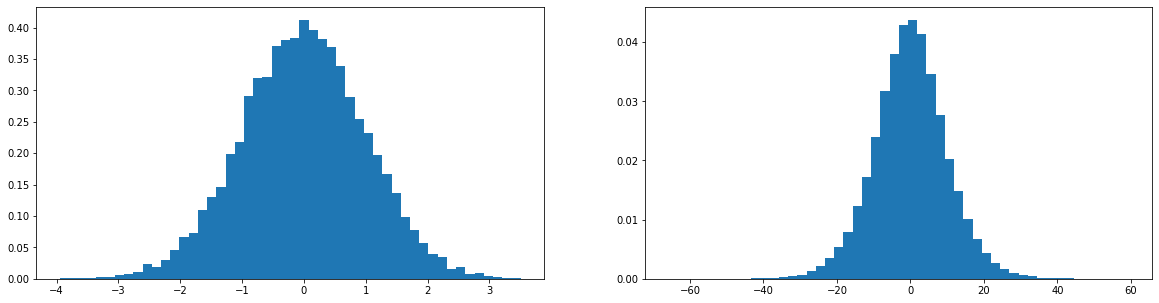

In [34]:
#### Getting Unit Gaussian

## Spread of y : Unit Gaussian

x = torch.randn((1000, 10), generator = g)
w = torch.randn((10, 200), generator = g)*(10**0.5) # 10 is the fan_in
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = "True")
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = "True")

#### Kaimimg He Initializtaion
- Automatic way of doing this : https://pytorch.org/docs/stable/nn.init.html
- Multiplication factor : (5/3)/sqrt(fan_in)

In [35]:
### Lets break after the first epoch
g = torch.Generator().manual_seed(2147483647)

block_size = 3
emb_dim = 10 # Embedding Dimension
n_hidden = 200 # Number of neurons in the Hidden Layer
C = torch.randn((vocab_size, emb_dim), generator = g)
W1 = torch.randn((block_size*emb_dim, n_hidden), generator = g)*(5/3)/((block_size*emb_dim)**0.5)
b1 = torch.randn(n_hidden, generator = g)*0
W2 = torch.randn((n_hidden, vocab_size), generator = g)*0.01
b2 = torch.randn(vocab_size, generator = g)*0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

#Setting the requires_grad parameter
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ## Mini-batch construct
    ix = torch.randint(low = 0, high = Xtr.shape[0], size = (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Get the mini-batch
    
    # Forward Pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation
    h = torch.tanh(hpreact) # Activation layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # Loss Function
    
    # Backward pass
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    # Updating the parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

11897
      0/ 200000: 3.3179


In [36]:
h

tensor([[ 0.7500, -0.1464, -0.8404,  ..., -0.5055, -0.9974,  0.9727],
        [-0.9791, -0.2742, -0.2752,  ...,  0.0705,  0.6874,  0.6104],
        [ 0.9366,  0.1919,  0.9444,  ...,  0.4202,  0.8313,  0.9706],
        ...,
        [-0.9829,  0.7132, -0.0532,  ..., -0.1305,  0.9656,  0.9715],
        [-0.9882,  0.1556, -0.4136,  ..., -0.1948,  0.9273,  0.9808],
        [-0.9829,  0.7132, -0.0532,  ..., -0.1305,  0.9656,  0.9715]],
       grad_fn=<TanhBackward0>)

(array([573., 297., 208., 162., 137., 132.,  99., 108., 112.,  92., 101.,
         72.,  59.,  74.,  75.,  81.,  75.,  64.,  81.,  84.,  77.,  74.,
         51.,  61.,  63.,  81.,  72.,  59.,  73.,  59.,  75.,  68.,  64.,
         78.,  93.,  97.,  69., 101.,  68., 107., 104.,  97., 108., 110.,
        152., 148., 210., 248., 338., 709.]),
 array([-9.99978602e-01, -9.59980237e-01, -9.19981873e-01, -8.79983509e-01,
        -8.39985144e-01, -7.99986780e-01, -7.59988415e-01, -7.19990051e-01,
        -6.79991686e-01, -6.39993322e-01, -5.99994957e-01, -5.59996593e-01,
        -5.19998229e-01, -4.79999864e-01, -4.40001500e-01, -4.00003135e-01,
        -3.60004771e-01, -3.20006406e-01, -2.80008042e-01, -2.40009677e-01,
        -2.00011313e-01, -1.60012949e-01, -1.20014584e-01, -8.00162196e-02,
        -4.00178552e-02, -1.94907188e-05,  3.99788737e-02,  7.99772382e-02,
         1.19975603e-01,  1.59973967e-01,  1.99972332e-01,  2.39970696e-01,
         2.79969060e-01,  3.19967425e-01,  3.59965

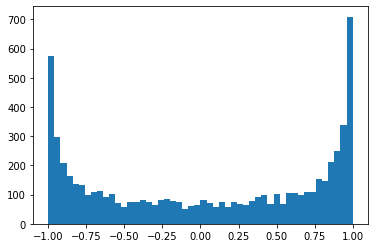

In [37]:
plt.hist(h.view(-1).tolist(), 50)

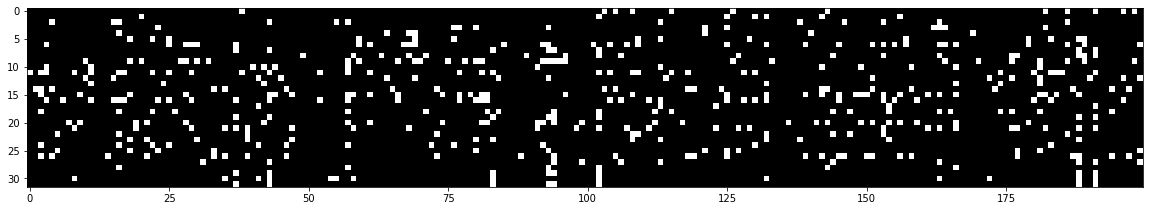

In [38]:
plt.figure(figsize = (20,18))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation = 'nearest')

### Batch Normalization
- Resolution for almost all of the problems above.
- What we want, is that the pre-activations are not very small(tanh) becomes inactive, or they are not very large as tanh is then saturated(no gradient flow).
- So we want them to be somewhat like unit Gaussian.
- Batch Normalization just normalizes the hprereact.
- Batch Normalization can tend top be very buggy because it is coupling all these together 
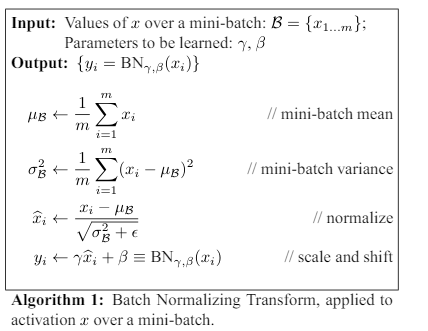

In [39]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2

# Since we are using Batch Normalization, we don't need the bias b1, as during the subtraction of mean, this bias goes away
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [40]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    ##Buffers
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # momentum : 0.001, for small batch size like 32, mean and std might not converge, so momentum is so less
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


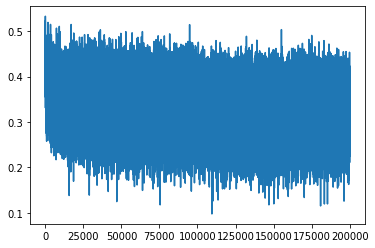

In [41]:
plt.plot(lossi)

#### Batch Normalization at Inference: Not done normally so the running bmean and bnstd are calculated

In [42]:
# Why batch Normalization at inference is different:
# Consider the case where we put a model in production and draw inference on just a single example
# How do we get the mean and std for the single example, we need an estimate of the mean and std at inference time\
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

### Pytorchifying our Code

In [43]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [44]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


#### Training

In [45]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
        
    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


### Some Diagnostic tools : Plots


#### Activation Distribution

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

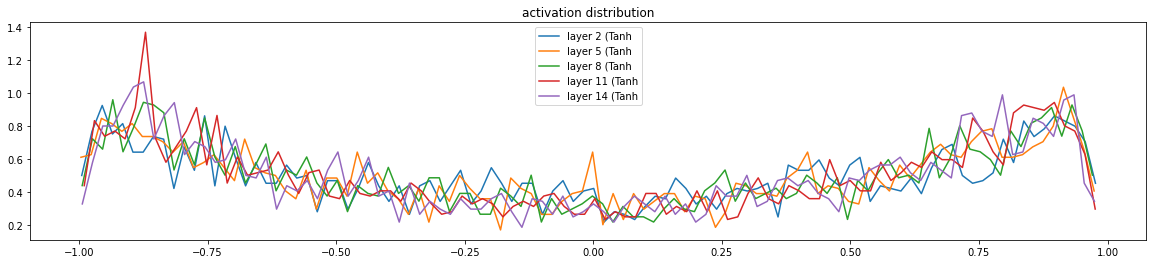

In [46]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#### Gradient Distribution

layer 2 (      Tanh): mean -0.000000, std 2.640701e-03
layer 5 (      Tanh): mean -0.000000, std 2.245583e-03
layer 8 (      Tanh): mean +0.000000, std 2.045740e-03
layer 11 (      Tanh): mean +0.000000, std 1.983132e-03
layer 14 (      Tanh): mean +0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

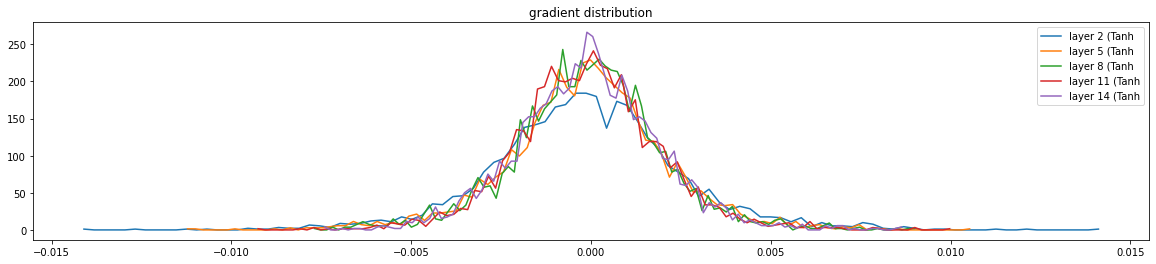

In [47]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#### Weights Gradient Distribution

weight   (27, 10) | mean -0.000000 | std 8.020528e-03 | grad:data ratio 8.012624e-03
weight  (30, 100) | mean +0.000246 | std 9.241068e-03 | grad:data ratio 4.881086e-02
weight (100, 100) | mean +0.000113 | std 7.132872e-03 | grad:data ratio 6.964612e-02
weight (100, 100) | mean -0.000086 | std 6.234297e-03 | grad:data ratio 6.073733e-02
weight (100, 100) | mean +0.000052 | std 5.742180e-03 | grad:data ratio 5.631476e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570122e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


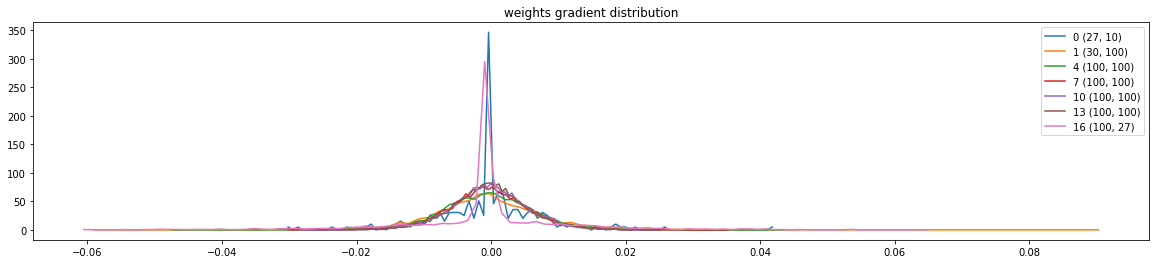

In [48]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


#### Grad:Data Ratio

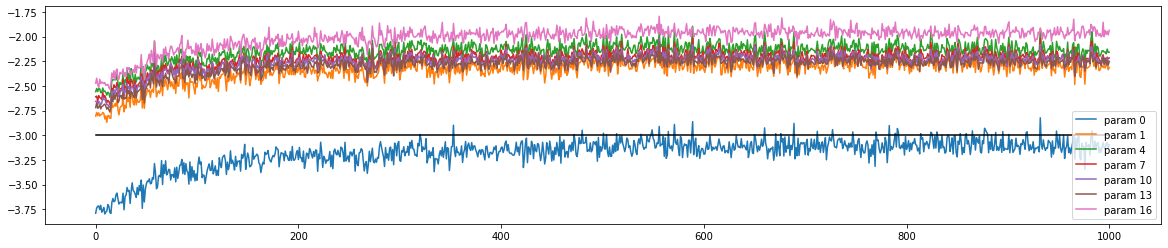

In [49]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
